# Trabajo Final. Análisis de Datos

## Alumnos:

### Domenje, Carlos R.

### Fux, Santiago.

---

## DATASET: Uso de Taxis Yellow Cab en USA en el año 2020

**Problema.** Responderemos a la siguiente pregunta

1. ¿Existe una manera de caracterizar los lugares más recurrentes para inicio / fin de viaje?


## 1. Obtención de datos

Para importar los datos, buscamos en la página web brindada por la cátedra:

- [Yellow Cab - Dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

**Nota**: El dataset utilizado será el del año 2020, los tres primeros meses (Enero, Febrero, Marzo) y será descargado en una carpeta llamada "data" dentro de la carpeta contenedora del proyecto.

In [2]:
# Path del dataset a utilizar.
DATASET_PATH = r'./data'

In [3]:
# listamos los archivos que se encuentran en el path
!ls {DATASET_PATH}

yellow_tripdata_2020-01.parquet yellow_tripdata_2020-03.parquet
yellow_tripdata_2020-02.parquet


In [4]:
# Importamos las librerias necesarias para interactuar con el dataset.

import pandas as pd
import glob
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import scipy.stats as stats
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler
from collections import Counter
# Set decimals format with 3 decimals
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
# El archivo del dataset tiene como formato .parquet, el cual es un archivo que esta orientado a columnas. 
all_files = glob.glob("./data/*.parquet")

df_list = []

for filename in all_files:
    # Se carga el archivo
    df = pd.read_parquet(filename)
    # Tomo el 10% del dataset total   
    df = df.sample(frac=0.1)
    # Agrego a la lista
    df_list.append(df)


df = pd.concat(df_list, axis=0, ignore_index=True)


df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1571207.000,1556030.000,1571207.000,1556030.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1556030.000
mean,1.673,1.503,2.897,1.058,164.493,162.310,1.252,12.610,1.106,0.492,2.190,0.329,0.298,18.551,2.297
std,0.470,1.144,30.831,0.825,65.760,69.994,0.486,11.686,1.256,0.073,2.688,1.805,0.035,14.292,0.706
min,1.000,0.000,-30.620,1.000,1.000,1.000,0.000,-500.000,-7.000,-0.500,-55.000,-38.230,-0.300,-500.300,-2.500
25%,1.000,1.000,0.970,1.000,125.000,113.000,1.000,6.500,0.000,0.500,0.000,0.000,0.300,11.160,2.500
50%,2.000,1.000,1.600,1.000,162.000,162.000,1.000,9.000,0.500,0.500,1.950,0.000,0.300,14.300,2.500
75%,2.000,2.000,2.930,1.000,234.000,234.000,2.000,14.000,2.500,0.500,2.860,0.000,0.300,19.890,2.500
max,6.000,9.000,34325.100,99.000,265.000,265.000,4.000,600.000,87.560,3.300,500.000,925.500,0.300,925.810,2.750


In [6]:
## Para obtener una descripción del tipo de datos que contiene cada columna, utilizamos la funcion info()
# Podemos además, obtener una idea general de cuantos datos no nulos contiene.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1571207 entries, 0 to 1571206
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   VendorID               1571207 non-null  int64         
 1   tpep_pickup_datetime   1571207 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  1571207 non-null  datetime64[ns]
 3   passenger_count        1556030 non-null  float64       
 4   trip_distance          1571207 non-null  float64       
 5   RatecodeID             1556030 non-null  float64       
 6   store_and_fwd_flag     1556030 non-null  object        
 7   PULocationID           1571207 non-null  int64         
 8   DOLocationID           1571207 non-null  int64         
 9   payment_type           1571207 non-null  int64         
 10  fare_amount            1571207 non-null  float64       
 11  extra                  1571207 non-null  float64       
 12  mta_tax                15712

In [7]:
# La función describe() nos da una vista general de valores de cantidades de datos, media, desv. standard, valores min y max de cada columna.
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1571207.000,1556030.000,1571207.000,1556030.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1571207.000,1556030.000
mean,1.673,1.503,2.897,1.058,164.493,162.310,1.252,12.610,1.106,0.492,2.190,0.329,0.298,18.551,2.297
std,0.470,1.144,30.831,0.825,65.760,69.994,0.486,11.686,1.256,0.073,2.688,1.805,0.035,14.292,0.706
min,1.000,0.000,-30.620,1.000,1.000,1.000,0.000,-500.000,-7.000,-0.500,-55.000,-38.230,-0.300,-500.300,-2.500
25%,1.000,1.000,0.970,1.000,125.000,113.000,1.000,6.500,0.000,0.500,0.000,0.000,0.300,11.160,2.500
50%,2.000,1.000,1.600,1.000,162.000,162.000,1.000,9.000,0.500,0.500,1.950,0.000,0.300,14.300,2.500
75%,2.000,2.000,2.930,1.000,234.000,234.000,2.000,14.000,2.500,0.500,2.860,0.000,0.300,19.890,2.500
max,6.000,9.000,34325.100,99.000,265.000,265.000,4.000,600.000,87.560,3.300,500.000,925.500,0.300,925.810,2.750


### Descripción de Columnas del Dataset.


In [8]:
# Listado de tipos de variables presentes en el dataset
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                      object
dtype: object

In [9]:
# funcion para plotear las distribuciones de los atributos
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=10, ylabelsize=10,figsize=(18,18))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout
    plt.show()
    

# funcion para imprimir nulos
def print_null_info(col):
    print(f'Cantidad de nulos: {col.isnull().sum()}/{col.size}')

# funcion para imprimir datos de v. categoricas
def print_categorical(col):
    print(f'Ordinalidad: {col.unique()}')
    print_null_info(col)
    print('Ocurrencias:')
    print(col.value_counts().sort_values())

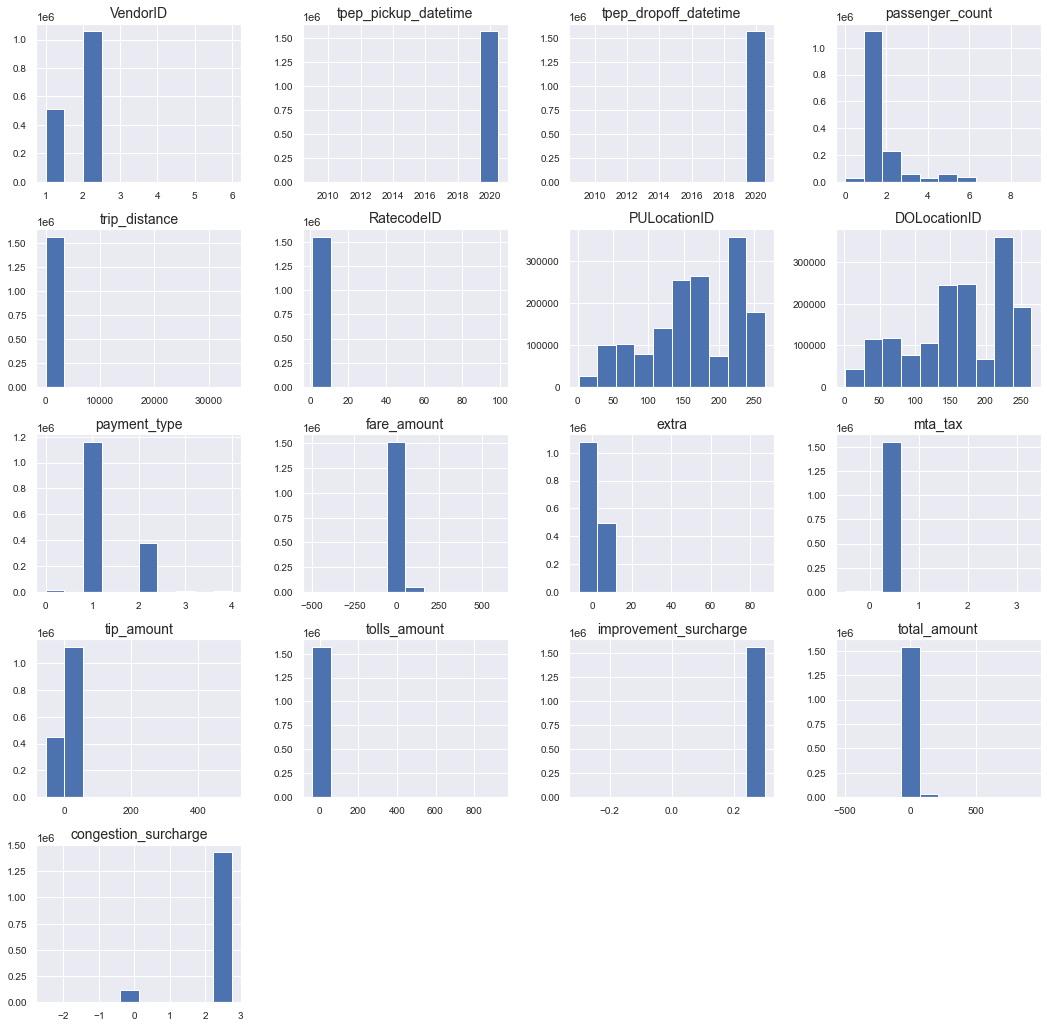

In [10]:
#imprimo distribuciones 
display_dataset_distributions(df)


- **VendorID**: Proveedor de servicios de tecnologias en taxis (T-PEP)
    - Tipo de dato: Categórica ordinal  
    - Tipo de variable: Entrada  


In [11]:
print_categorical(df.VendorID)

Ordinalidad: [2 1 6 5]
Cantidad de nulos: 0/1571207
Ocurrencias:
5          1
6         56
1     513696
2    1057454
Name: VendorID, dtype: int64



- **tpep_pickup_datetime**: Fecha y hora en el cual el reloj fue activado al iniciar un viaje.
    - Tipo de dato: Timestamp compuesto  
    - Tipo de variable: Entrada  

    - Ejemplo del dato en el dataset: 2020-07-01 00:25:32


In [12]:
print_null_info(df.tpep_pickup_datetime)

Cantidad de nulos: 0/1571207


- **tpep_dropoff_datetime**: Fecha y hora en el cual el reloj fue desactivador al finalizar un viaje.
    - Tipo de dato: Timestamp compuesto
    - Tipo de variable: Entrada  / Salida

    - Ejemplo del dato en el dataset: 2020-07-01 00:33:39


In [13]:
print_null_info(df.tpep_dropoff_datetime)

Cantidad de nulos: 0/1571207


- **passenger_count**: El número de pasajeros en el vehiculo. (Es un dato que lo ingresa el conductor.)
    - Tipo de dato: Numérico 
    - Tipo de variable: Entrada
    - Ejemplo del dato en el dataset: 1.0

In [14]:
print_null_info(df.passenger_count)

Cantidad de nulos: 15177/1571207



- **trip_distance**: La distancia del viaje transcurrido en millas reportada por el taxímetro. 
    - Tipo de dato: Numérico 
    - Tipo de variable: Entrada  

    - Ejemplo del dato en el dataset: 1.50


In [15]:
print_null_info(df.trip_distance)

Cantidad de nulos: 0/1571207


- **PULocationID**: TLC Zona en la que el taxímetro se activó.
    - Tipo de dato: Categórica ordinal
    - Tipo de variable: Entrada / Salida

    - Ejemplo del dato en el dataset: 238


In [16]:
print_categorical(df.PULocationID)

Ordinalidad: [170 230 236 141  79 231 186  48 234 215  43 237  90 148 132 133 163 166
  87  42 249 100 262 246 263 238  68  41  75 138 142 144 113 229 239 233
 211 140  29 143 125 137 209 151 158 261 107   4 164 165 162 161  50  77
  61 129  62 114  13  45 146  88 232  25  74 264 145 152 224 255  24  47
 150  51   8 116 218  89  65  12   9 179  97 235 196 119 193 226   7  95
 265 181 168 256 159  52  10 247 244 188  72  39 198 242 203 250  49 155
  26 147  66  33 223 157  40  93 192 228  76 260  80  82 185  28 139  19
  22 200 182  21 191  20 106  38 130 258 190  85 177 171  35 205 225 197
 213  14 227  78 117 202 178  17 241 220 208 112 121  18 222 174 123  36
  91 195  70 111 219 167  56 134 216 243 221  92 207 160  37  69 189 180
 136  83 131  55 122 127 169 210 194 153   3 102 135 183  58  34   1  63
 257 201 254 217  64  94  81 124  23 101 259 149  15 173  53 108  32  16
  71 115  96 252 214 126  86  60 187 240  98  54  73  46 175  11 212  67
 128 118 154   6 248  44 206 156  31  


- **DOLocationID**: TLC Zona en la que el taxímetro se desactivó.
    - Tipo de dato: Categórica ordinal
    - Tipo de variable: Entrada / Salida 

    - Ejemplo del dato en el dataset: 75


In [17]:
print_categorical(df.DOLocationID)

Ordinalidad: [224 257 163 229 233 137 209 230 181 170 263 238  68 114 130 234  62 158
 161  41 140 147 246 237  48 113 162 239   7  74  90 186 236 142 107  79
  24 143  50 231 182  93 264 148 262 100 132 232  87  80 249 165  88 256
  13  33  75 164 144  66  35 138 261  77  17   4 223  97  76 166 141 116
  43 145 179 151  65 119  47  42  53 211  56  25 265 243  95   1  63 146
 196 255 200 127 189 244 129 168 185 216 225 188  16  67 157 125 152 112
  10   9  28 203 213  52  70 136  85 247 193 198  89 217 260  37 258 254
 242 226 117 218 212  49 118  45 171 197 195 106  14  29 102 248  83 134
 159  61 169 155  78  22  92 149  26  71 121 177 174  51  98  82 252 131
  36 228  39 253  40  72 202  73 160 133 175 191 235 167 101 241  54 215
 178  21 227 135 108 190 126 139 201  20  69 219   6 194 124   3 173 184
  18 206  19 221 205 128 222 220  64  34 208  38 207 123  86  91  12 120
 259  60  94 150  32   8  11 204 210 153 180  55  15  81 192  99 250 183
 245 122  58 214  96 240  59 176  84  


- **RatecodeID**:  El código de tarifa final vigente al final del viaje.
    - Tipo de dato: Categórica ordinal
    - Tipo de variable: Entrada  

    - 1= Standard rate
    - 2= JFK 
    - 3= Newark
    - 4= Nassau or Westchester
    - 5= Negotiated fare
    - 6= Group ride


In [18]:
print_categorical(df.RatecodeID)

Ordinalidad: [ 1. nan  2.  5.  3.  4. 99.  6.]
Cantidad de nulos: 15177/1571207
Ocurrencias:
6.000           7
99.000         90
4.000        1233
3.000        3205
5.000        8690
2.000       35785
1.000     1507020
Name: RatecodeID, dtype: int64


- **store_and_fwd_flag**:  Este flag indica si el registro de viaje se llevó a cabo en la memoria del dispositivo del vehiculo antes de enviar al proveedor, también conocido como "almacenar y reenviar", porque el vehiculo no tenia conexion al servidor.
    - Tipo de dato: Categórica  
    - Tipo de variable: Entrada  

    - Y= Almacenar y reenviar informacion.
    - N= No almacenar y enviar informacion.


In [19]:
print_categorical(df.store_and_fwd_flag)

Ordinalidad: ['N' None 'Y']
Cantidad de nulos: 15177/1571207
Ocurrencias:
Y      16018
N    1540012
Name: store_and_fwd_flag, dtype: int64



- **payment_type**: Un código numérico que significa cómo el pasajero pagó por el viaje.
    - Tipo de dato: Categórica ordinal  
    - Tipo de variable: Entrada  

    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip


In [20]:
print_categorical(df.payment_type)

Ordinalidad: [1 2 0 3 4]
Cantidad de nulos: 0/1571207
Ocurrencias:
4       4598
3       8196
0      15177
2     381418
1    1161818
Name: payment_type, dtype: int64


- **fare_amount**: La tarifa de tiempo y distancia calculada por el taxímetro.
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 8.0


In [21]:
print_null_info(df.fare_amount)

Cantidad de nulos: 0/1571207


- **Extra**: Varios extras y recargos. Actualmente, esto solo incluye los cargos de $0.50 y $1 por la hora pico y por la noche.
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 0.5


In [22]:
print_null_info(df.extra)

Cantidad de nulos: 0/1571207



- **mta_tax**: Impuesto MTA de $0.50 que se activa automáticamente según la tasa de uso del medidor.
    - Tipo de dato: Numérico
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 0.5


In [23]:
print_null_info(df.mta_tax)

Cantidad de nulos: 0/1571207


- **improvement_surcharge**: Recargo de mejora de $ 0.30 en viaje en el descenso de bandera. El recargo por mejora comenzó a cobrarse en 2015.
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 0.3


In [24]:
print_null_info(df.improvement_surcharge)

Cantidad de nulos: 0/1571207


- **tip_amount**: Importe de la propina: este campo se completa automáticamente para las propinas de tarjetas de crédito. Las propinas en efectivo no están incluidas.
    - Tipo de dato: Numérico
    - Tipo de variable: Salida  

    - Ejemplo del dato en el dataset: 0.00  


In [25]:
print_null_info(df.tip_amount)

Cantidad de nulos: 0/1571207


- **tolls_amount**: Importe total de todos los peajes pagados en el viaje.
    - Tipo de dato: Numérico
    - Tipo de variable: Salida  
    - Ejemplo del dato en el dataset: 0.00


In [26]:
print_null_info(df.tolls_amount)

Cantidad de nulos: 0/1571207



- **total_amount**: El monto total cobrado a los pasajeros. No incluye propinas en efectivo.
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida  
    - Ejemplo del dato en el dataset: 9.30


In [27]:
print_null_info(df.total_amount)

Cantidad de nulos: 0/1571207


- **congestion_surcharge**: Importe total recaudado en el viaje por el recargo por congestión del Estado de Nueva York.
    - Tipo de dato: Numérico
    - Tipo de variable: Salida  
    - Ejemplo del dato en el dataset: 0.00


In [28]:
print_null_info(df.congestion_surcharge)

Cantidad de nulos: 15177/1571207


- **airport_fee**: $1.25 para recoger solo en los aeropuertos LaGuardia y John F. Kennedy
    - Tipo de dato: Numérico  
    - Tipo de variable: Salida
    - Ejemplo del dato en el dataset: None

In [29]:
print_null_info(df.airport_fee)

Cantidad de nulos: 1571207/1571207


## 2. Limpieza de los datos


### 2.1 Datos faltantes

In [30]:
# verificamos cantidad de items repetidos y los eliminamos
df = df.drop_duplicates()
df.describe() #TODO: Agrego describe para que se noten las cantidades eliminadas

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1571089.000,1556030.000,1571089.000,1556030.000,1571089.000,1571089.000,1571089.000,1571089.000,1571089.000,1571089.000,1571089.000,1571089.000,1571089.000,1571089.000,1556030.000
mean,1.673,1.503,2.897,1.058,164.495,162.313,1.252,12.608,1.106,0.492,2.190,0.329,0.298,18.550,2.297
std,0.470,1.144,30.832,0.825,65.759,69.993,0.486,11.685,1.256,0.073,2.688,1.805,0.035,14.291,0.706
min,1.000,0.000,-30.620,1.000,1.000,1.000,0.000,-500.000,-7.000,-0.500,-55.000,-38.230,-0.300,-500.300,-2.500
25%,1.000,1.000,0.970,1.000,125.000,113.000,1.000,6.500,0.000,0.500,0.000,0.000,0.300,11.160,2.500
50%,2.000,1.000,1.600,1.000,162.000,162.000,1.000,9.000,0.500,0.500,1.950,0.000,0.300,14.300,2.500
75%,2.000,2.000,2.930,1.000,234.000,234.000,2.000,14.000,2.500,0.500,2.860,0.000,0.300,19.850,2.500
max,6.000,9.000,34325.100,99.000,265.000,265.000,4.000,600.000,87.560,3.300,500.000,925.500,0.300,925.810,2.750


In [31]:
# verificamos cantidad de nulos en cada categoría
for i in range(len(df.columns)):
  col_name = df.columns[i]
  col_data = df[col_name]
  print(f'{col_name}: {col_data.isnull().sum()}/{col_data.size}')

VendorID: 0/1571089
tpep_pickup_datetime: 0/1571089
tpep_dropoff_datetime: 0/1571089
passenger_count: 15059/1571089
trip_distance: 0/1571089
RatecodeID: 15059/1571089
store_and_fwd_flag: 15059/1571089
PULocationID: 0/1571089
DOLocationID: 0/1571089
payment_type: 0/1571089
fare_amount: 0/1571089
extra: 0/1571089
mta_tax: 0/1571089
tip_amount: 0/1571089
tolls_amount: 0/1571089
improvement_surcharge: 0/1571089
total_amount: 0/1571089
congestion_surcharge: 15059/1571089
airport_fee: 1571089/1571089


#### 2.1.1 Análisis de faltantes

Las categorías con faltantes son las siguientes:

* passenger_count: 15180/1571072
* RatecodeID: 15180/1571072
* store_and_fwd_flag: 15180/1571072
* congestion_surcharge: 15180/1571072
* airport_fee: 1571072/1571072

Para cada una de estas columnas se decide:
* __passenger_count__ es ingresado a mano por lo que los datos faltantes suponemos que corresponden a fallas en la carga por parte del conductor. Se decide eliminar los faltantes dado que representan el 1%
* __RatecodeID__ no aporta información por lo que se elimina esta feature
* __store_and_fwd_flag__ no aporta información por lo que se elimina esta feature
* __congestion_surcharge__ : los faltantes representan el 1% por lo que se quitan
* __airport_fee__ se quita ya que todos los valores son nulos


In [32]:
# descarto datos nulos de los features con interés (passenger count y congestion_surcharge)
df = df.dropna(subset=['passenger_count', 'congestion_surcharge'])
len(df['passenger_count'])

1556030

#### 2.1.2 Datos no nulos inválidos

En algunos features se detectan valores fuera del rango esperado (tal como valores negativos o fuera del rango de las categorías definidas)

In [33]:
# verificamos cantidad de negativos en las categorías numéricas
cols_to_check = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge']

for i, col in enumerate(cols_to_check):
  col_data = df[col]
  print(f'{col}: {col_data[col_data < 0].count()}/{col_data.size}')
  

trip_distance: 0/1556030
fare_amount: 5091/1556030
extra: 2458/1556030
mta_tax: 4975/1556030
tip_amount: 56/1556030
tolls_amount: 111/1556030
improvement_surcharge: 5087/1556030
total_amount: 5091/1556030
congestion_surcharge: 4023/1556030


In [34]:
# Funcion para realizar subplots de variables

def plotVariables(dataframe, varArray):
    fig = plt.figure(figsize=(30,15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for j,colName in enumerate(varArray):
        plt.subplot(3,3,j+1)
        plt.plot(dataframe[colName])
        plt.title(colName)
        

#### Exploración gráfica de variables con datos negativos

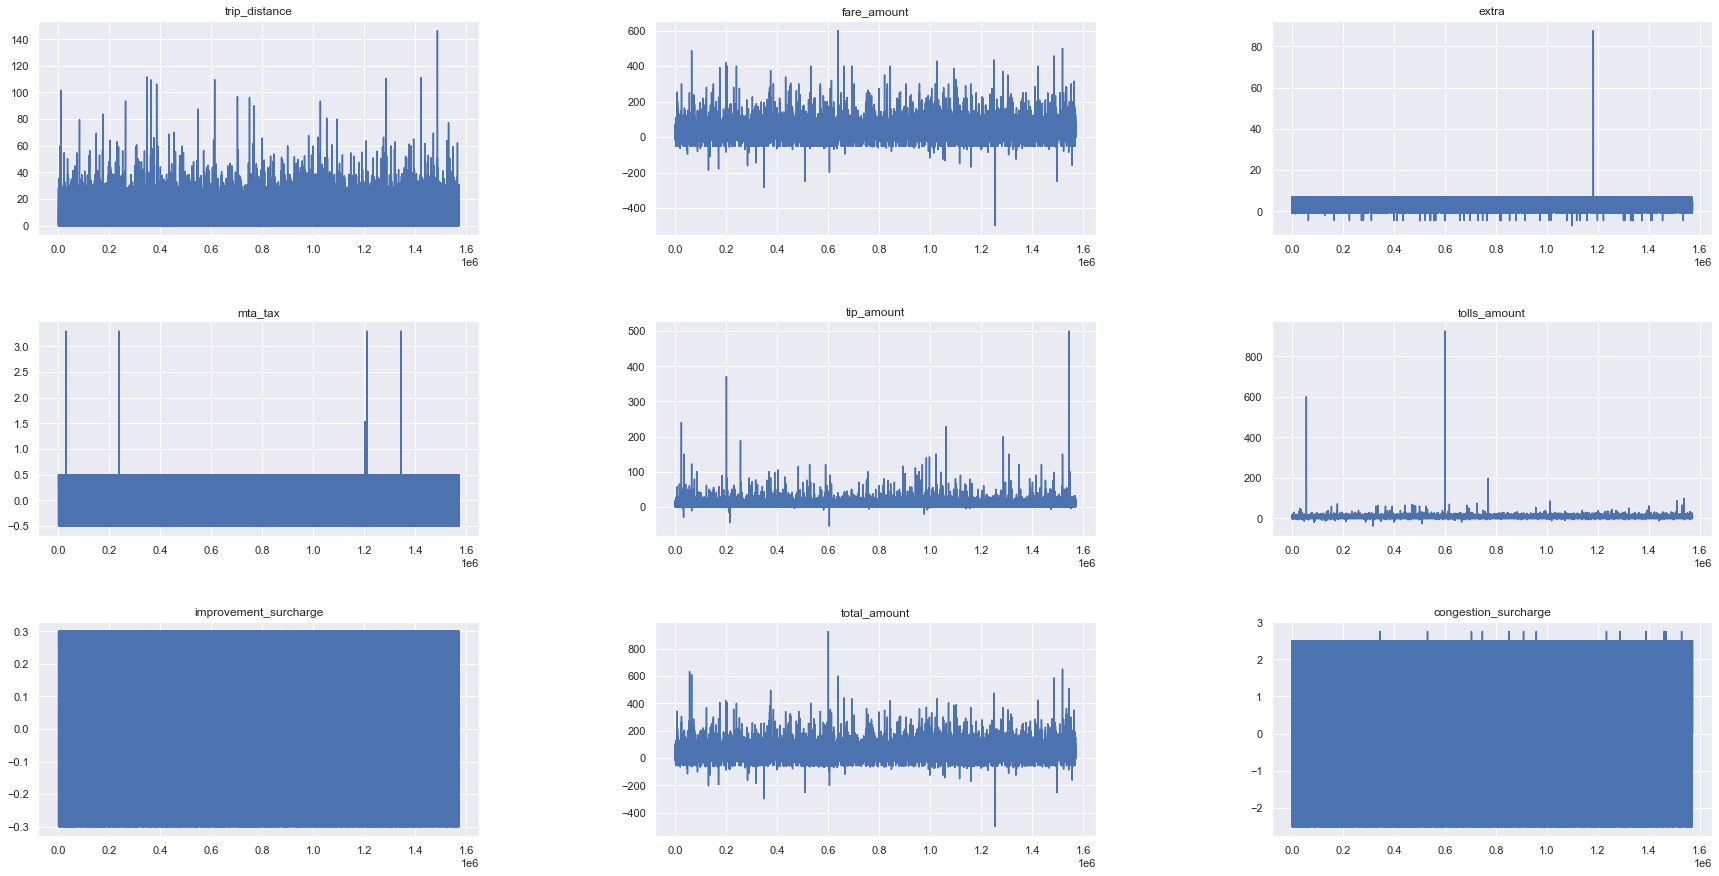

In [35]:
 #TODO: Agrego graficos para mostrar estos datos anomalos.
# Exploración gráfica de variables con datos negativos.

colArrays = ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 
            'tip_amount', 'tolls_amount', 'improvement_surcharge', 
            'total_amount', 'congestion_surcharge']

plotVariables(df,colArrays)


In [36]:
# trip distance: borro <= 0
df = df[(df['trip_distance'] > 0)]
# fare_amount: borro < 0
df = df[(df['fare_amount'] >= 0)]
# extra: borro < 0
df = df[(df['extra'] >= 0)]
# mta_tax: borro < 0
df = df[(df['mta_tax'] >= 0)]
# tip_amount: borro < 0
df = df[(df['tip_amount'] >= 0)]
#tolls amount: borro < 0
df = df[(df['tolls_amount'] >= 0)]
#improvement_surcharge: borro < 0
df = df[(df['improvement_surcharge'] >= 0)]
#total_amount: borro < 0
df = df[(df['total_amount'] >= 0)]
#congestion_surcharge: borro < 0
df = df[(df['congestion_surcharge'] >= 0)]

len(df)



1535521

#### Exploración gráfica de datos filtrados


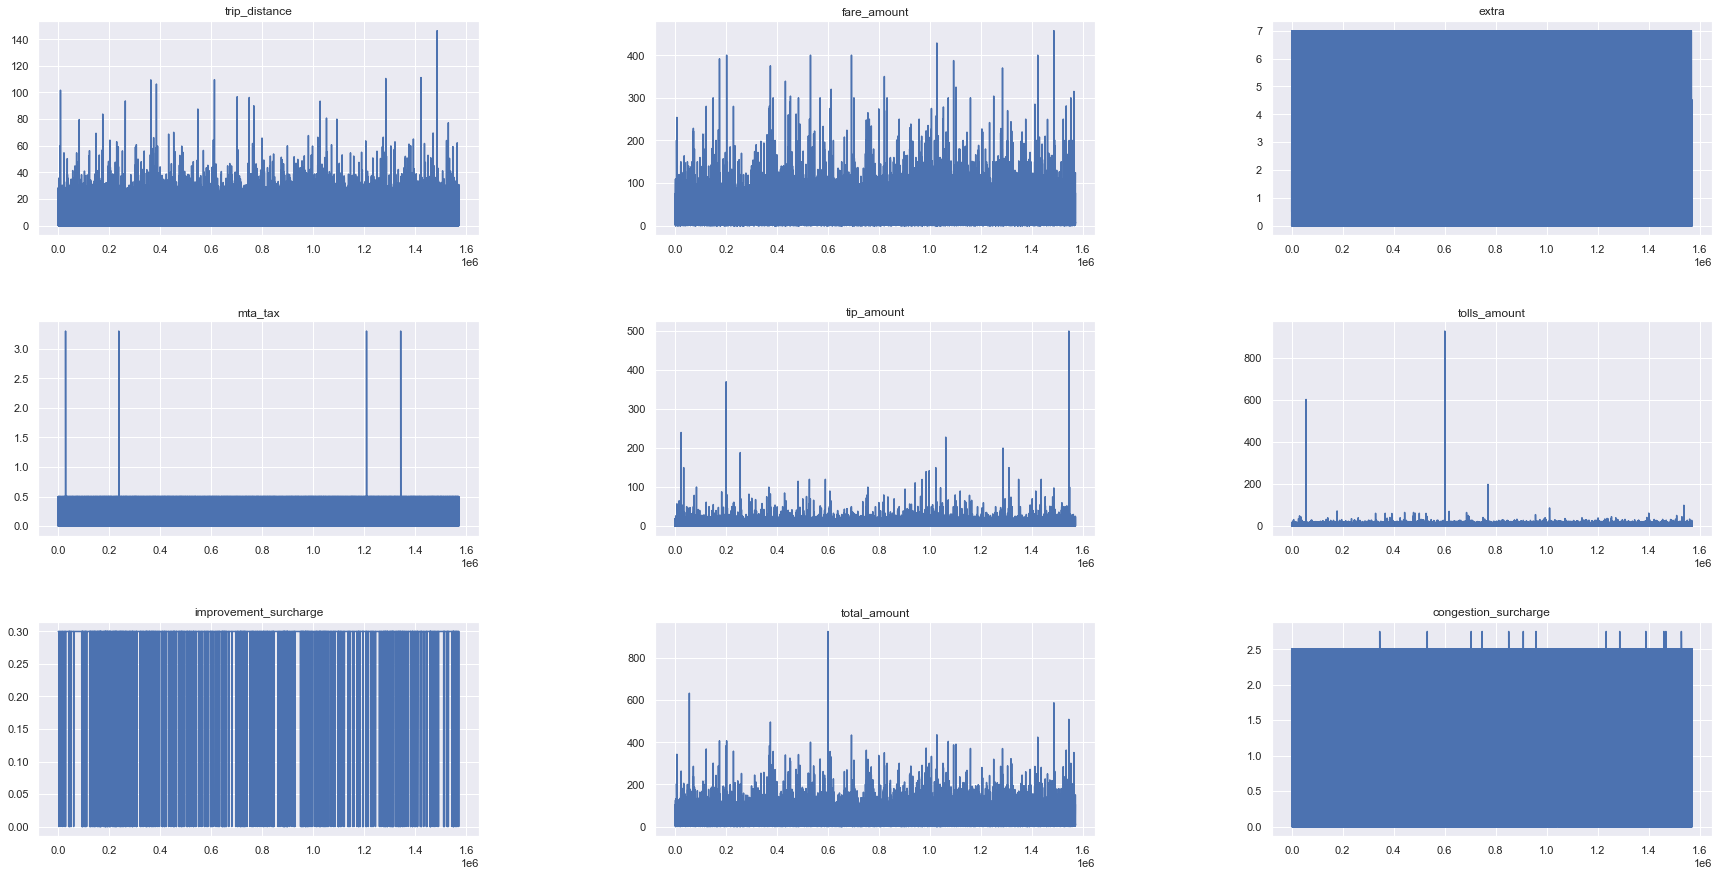

In [37]:
# Datos sin valores negativos
plotVariables(df,colArrays)

#### 2.1.3 Filtro entradas por tipo de pago
Descarto otros pagos diferenes de CREDIT (payment_type = 1)

In [38]:
df = df[df["payment_type"] == 1]
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1151915.000,1151915.000,1151915.000,1151915.000,1151915.000,1151915.000,1151915.000,1151915.000,1151915.000,1151915.000,1151915.000,1151915.000,1151915.000,1151915.000,1151915.000
mean,1.671,1.495,2.864,1.040,166.115,163.974,1.000,12.454,1.130,0.498,2.945,0.338,0.300,19.266,2.380
std,0.470,1.141,3.669,0.296,65.235,69.330,0.000,10.911,1.254,0.031,2.651,1.589,0.003,13.989,0.535
min,1.000,0.000,0.010,1.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,1.000,1.000,132.000,113.000,1.000,6.500,0.000,0.500,1.730,0.000,0.300,11.800,2.500
50%,2.000,1.000,1.650,1.000,162.000,162.000,1.000,9.000,0.500,0.500,2.320,0.000,0.300,14.800,2.500
75%,2.000,2.000,2.910,1.000,234.000,234.000,1.000,13.500,2.500,0.500,3.260,0.000,0.300,20.350,2.500
max,2.000,7.000,146.400,99.000,265.000,265.000,1.000,457.500,7.000,3.300,500.000,198.000,0.300,587.300,2.750


### 2.2 Ingeniería de datos

#### 2.2.1 Features de tiempo y hora del día

In [39]:
# generamos una nueva columna "duration" con el tiempo de viaje
ts_init = pd.to_datetime(df['tpep_pickup_datetime']).values.astype(np.int64) / 1000000000
ts_end = pd.to_datetime(df['tpep_dropoff_datetime']).values.astype(np.int64) / 1000000000
duration = ts_end - ts_init
df['duration'] = duration

# ademas creamos 3 categorías para el horario en que se inició el viaje: diurno, vespertino y nocturno
MORNING_START = 6
MORNING_END = 13
AFTERNOON_START = 14
AFTERNOON_END = 20
EVENING_START = 21
EVENING_END = 5 

day_interval = df['tpep_pickup_datetime'].dt.hour
df['morning'] = pd.cut(day_interval, bins=[-float('Inf'), MORNING_START - 1, MORNING_END, float('Inf')], labels=[0, 1, 0], ordered=False)
df['afternoon'] = pd.cut(day_interval, bins=[-float('Inf'), AFTERNOON_START - 1, AFTERNOON_END, float('Inf')], labels=[0, 1, 0], ordered=False)
df['evening'] = pd.cut(day_interval, bins=[-float('Inf'), 0, EVENING_END, EVENING_START, 23, float('Inf')], labels=[0, 1, 0, 1, 0], ordered=False)

# reviso que sean validas 
df['morning'].values.isnull().sum(), df['afternoon'].values.isnull().sum(), df['evening'].values.isnull().sum()

(0, 0, 0)

In [40]:
# termino de borrar todos los negativos
df['morning'].values.isnull().sum(), df['afternoon'].values.isnull().sum(), df['evening'].values.isnull().sum()

# verifico si tengo entradas con duration < 0
duration_invalid = df[df['duration'] < 0]['duration'].count()
print(f'Duraciones inválidas: {duration_invalid}')

Duraciones inválidas: 1


In [41]:
# Se eliminan las duraciones invalidas
df = df[(df['duration'] >= 0)]

#### 2.2.2 Codificación del origen y destino

[(237, 52810), (161, 51930), (236, 50833), (162, 44848), (186, 39438), (230, 38924), (234, 37793), (170, 36820), (142, 35317), (48, 33049)]
[(0, 730152), (237, 52810), (161, 51930), (236, 50833), (162, 44848), (186, 39438), (230, 38924), (234, 37793), (170, 36820), (142, 35317), (48, 33049)]


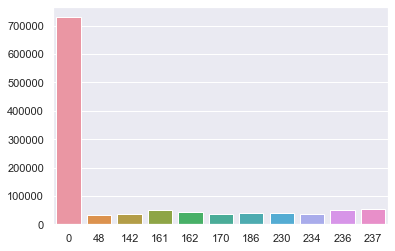

In [42]:
# definimos el umbral mínimo de cantidad de viajes para podar las categorías PULocationID y DOLocationID.
# location_id_min_th_count = 0.01
# total_items = len(df['PULocationID'])

# # convertimos PULocationID usando frequency encoding y me quedo con los que representan al menos 1%
# pulocation_id_freq_map = (df['PULocationID'].value_counts(sort=True) / total_items).to_dict()
# df['PULocationIDFreq'] = df['PULocationID'].apply(lambda x: pulocation_id_freq_map[x])
# # # convertimos DOLocationID
# # dolocation_id_freq_map = (df['DOLocationID'].value_counts(sort=True) / total_items).to_dict()
# # df['DOLocationIDFreq'] = df['DOLocationID'].apply(lambda x: dolocation_id_freq_map[x])

# #pongo en 0 todas las categorías con menor frecuencia que <location_id_min_th_count>
# def clear_location_low_values(x, th):
#   if x <= th:
#     return 0
#   return x

# df['PULocationIDFreq'] = df['PULocationIDFreq'].apply(lambda x: clear_location_low_values(x, location_id_min_th_count))
# # df['DOLocationIDFreq'] = df['DOLocationIDFreq'].apply(lambda x: clear_location_low_values(x, location_id_min_th_count))
# Contamos las apariciones de los lugares mas concurridos
from turtle import color


mostPickUpSites = Counter(df['PULocationID'])

# Mostramos los 10 primeros.
print(mostPickUpSites.most_common(10))

aux = mostPickUpSites.most_common(10)
most_pickup_important_places = []
for i in aux:
    most_pickup_important_places.append(i[0])

    
# for i, placeValue in enumerate(df['DOLocationID']):
#     if (not placeValue in most_important_places):
#         df.loc[i,'DOLocationID'] = 0

df['PULocationID'] = np.where(df['PULocationID'].isin(most_pickup_important_places), df['PULocationID'], 0)

type_feature = df['PULocationID'].value_counts()

sns.barplot(x=type_feature.index, y=type_feature.values, data=df['PULocationID'])
commonPickUpSites = Counter(df['PULocationID'])
# Mostramos los 10 primeros.
print(commonPickUpSites.most_common(20))


#### 2.2.3 Balance de la variable de salida

In [43]:
#verifico el rango de los ids
df['DOLocationID'].min(), df['DOLocationID'].max()


(1, 265)

In [44]:
#asigno a la categoria 0 a todos los que aparecen por debajo del 1%
# location_id_min_th_count = 0.01 * len(df)
# df['DOLocationIDTruncated'] = df['DOLocationID'].apply(lambda x: clear_location_low_values(x, location_id_min_th_count))
# df['DOLocationIDTruncated'].values[:10], location_id_min_th_count


[(236, 54043), (237, 47800), (161, 44572), (170, 37449), (162, 35566), (234, 33063), (142, 32709), (239, 32353), (141, 31646), (230, 30688)]
[(0, 772025), (236, 54043), (237, 47800), (161, 44572), (170, 37449), (162, 35566), (234, 33063), (142, 32709), (239, 32353), (141, 31646), (230, 30688)]


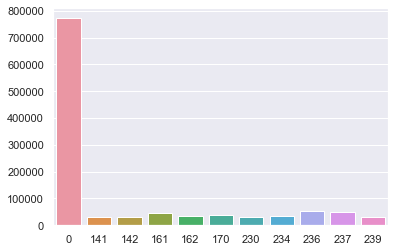

In [45]:


# Contamos las apariciones de los lugares mas concurridos
mostCommonSites = Counter(df['DOLocationID'])

# Mostramos los 10 primeros.
print(mostCommonSites.most_common(10))

aux = mostCommonSites.most_common(10)
most_important_places = []
for i in aux:
    most_important_places.append(i[0])

    
# for i, placeValue in enumerate(df['DOLocationID']):
#     if (not placeValue in most_important_places):
#         df.loc[i,'DOLocationID'] = 0

df['DOLocationID'] = np.where(df['DOLocationID'].isin(most_important_places), df['DOLocationID'], 0)

type_feature = df['DOLocationID'].value_counts()

sns.barplot(x=type_feature.index, y=type_feature.values, data=df['DOLocationID'])
commonSites = Counter(df['DOLocationID'])
# Mostramos los 10 primeros.
print(commonSites.most_common(20))

In [46]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration
count,1151914.000,1151914.000,1151914.000,1151914.000,1151914.000,1151914.000,1151914.000,1151914.000,1151914.000,1151914.000,1151914.000,1151914.000,1151914.000,1151914.000,1151914.000,1151914.000
mean,1.671,1.495,2.864,1.040,67.827,65.127,1.000,12.454,1.130,0.498,2.945,0.338,0.300,19.266,2.380,949.650
std,0.470,1.141,3.669,0.296,94.865,95.703,0.000,10.910,1.254,0.031,2.651,1.589,0.003,13.989,0.535,3569.593
min,1.000,0.000,0.010,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,1.000,1.000,0.000,0.000,1.000,6.500,0.000,0.500,1.730,0.000,0.300,11.800,2.500,400.000
50%,2.000,1.000,1.650,1.000,0.000,0.000,1.000,9.000,0.500,0.500,2.320,0.000,0.300,14.800,2.500,645.000
75%,2.000,2.000,2.910,1.000,162.000,161.000,1.000,13.500,2.500,0.500,3.260,0.000,0.300,20.350,2.500,1022.000
max,2.000,7.000,146.400,99.000,237.000,239.000,1.000,457.500,7.000,3.300,500.000,198.000,0.300,587.300,2.750,86391.000


### 2.3 Selección final de las features

En base al procesamiento anterior, seleccionamos los siguientes features del dataset:

In [47]:

feature_cols = [
  'passenger_count', 'trip_distance', 'fare_amount', 'extra', 
  'mta_tax', 'tip_amount', 'tolls_amount', 
  'improvement_surcharge', 'total_amount', 
  'congestion_surcharge', 'duration', 'PULocationID',
  'morning', 'afternoon', 'evening']
target_col = ['DOLocationID']

X = df[feature_cols]
y = df[target_col]

X.head()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration,PULocationID,morning,afternoon,evening
0,1.000,2.990,15.500,0.500,0.500,3.860,0.000,0.300,23.160,2.500,1347.000,170,0,0,0
2,1.000,1.700,10.000,2.500,0.500,2.650,0.000,0.300,15.950,2.500,831.000,236,1,0,0
3,0.000,1.300,6.500,2.500,0.500,1.000,0.000,0.300,10.800,2.500,318.000,0,1,0,0
4,1.000,1.770,7.500,0.500,0.500,2.260,0.000,0.300,13.560,2.500,437.000,0,0,0,1
5,1.000,2.900,13.500,2.500,0.500,0.500,0.000,0.300,17.300,2.500,1063.000,0,0,1,0


#### Eliminacion de datos con baja varianza

In [48]:
# TODO
from statistics import variance
from sklearn.feature_selection import VarianceThreshold

constant_filter = VarianceThreshold(threshold=0.01)

#Fit and transforming on train data
data_constant = constant_filter.fit_transform(X)
print(X.shape)
print(data_constant.shape)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in X.columns
                    if column not in X.columns[constant_filter.get_support()]]

#No. of constant columns
print(len(constant_columns))

#Constant columns names:
for column in constant_columns:
    print(column)
    
variance_X = X.drop(constant_columns,axis=1)
variance_X.shape

(1151914, 15)
(1151914, 13)
2
mta_tax
improvement_surcharge


(1151914, 13)

In [49]:
variance_X.head()

,passenger_count,trip_distance,fare_amount,extra,tip_amount,tolls_amount,total_amount,congestion_surcharge,duration,PULocationID,morning,afternoon,evening
0,1.000,2.990,15.500,0.500,3.860,0.000,23.160,2.500,1347.000,170,0,0,0
2,1.000,1.700,10.000,2.500,2.650,0.000,15.950,2.500,831.000,236,1,0,0
3,0.000,1.300,6.500,2.500,1.000,0.000,10.800,2.500,318.000,0,1,0,0
4,1.000,1.770,7.500,0.500,2.260,0.000,13.560,2.500,437.000,0,0,0,1
5,1.000,2.900,13.500,2.500,0.500,0.000,17.300,2.500,1063.000,0,0,1,0


#### Duracion de viaje vs Distancia recorrida.

<AxesSubplot:xlabel='duration', ylabel='trip_distance'>

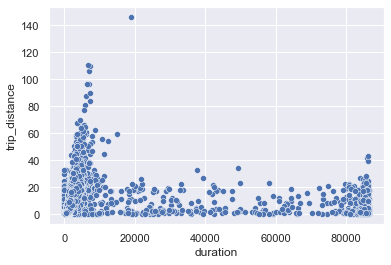

In [50]:
# Grafico de duracion de viaje vs distancia recorrida.
sns.scatterplot(x='duration', y='trip_distance', data=variance_X)

#### Grafico de total cobrado vs distancia del viaje

<AxesSubplot:xlabel='trip_distance', ylabel='total_amount'>

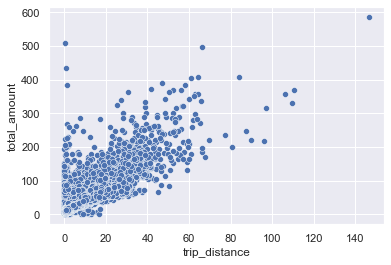

In [51]:
# Grafico de duracion de viaje vs total cobrado.
sns.scatterplot(x='trip_distance', y='total_amount', data=variance_X)

#### Grafico de distancia recorrida vs propina dada

<AxesSubplot:xlabel='trip_distance', ylabel='tip_amount'>

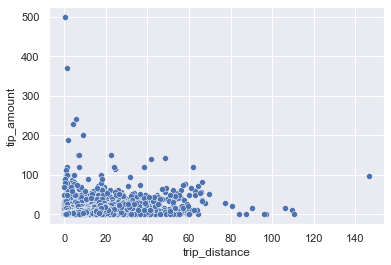

In [52]:
# Grafico de duracion de viaje vs propinas.
sns.scatterplot(x='trip_distance', y='tip_amount', data=variance_X)

<AxesSubplot:xlabel='tip_amount', ylabel='total_amount'>

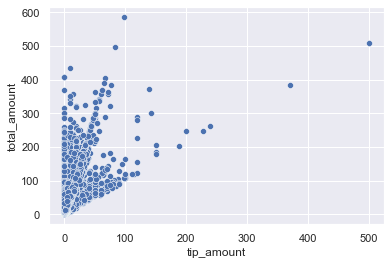

In [53]:
# Grafico de propinas vs total_cobrado.
sns.scatterplot(x='tip_amount', y='total_amount', data=variance_X)

<AxesSubplot:xlabel='PULocationID', ylabel='total_amount'>

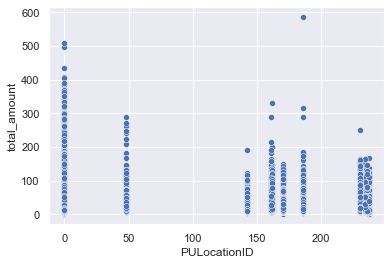

In [55]:
# Grafico de lugares donde se inicio el viaje con mayor valor cobrado.
sns.scatterplot(x='PULocationID', y='total_amount', data=variance_X)

In [52]:
y.shape

(1151282, 1)

## 3.Entrenamiento de modelos 
### 3.1 Separación de datos


In [53]:
# Particionamos en train y test
train_ratio = 0.7
test_ratio = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)


In [54]:
#imprimo tamaños de los dataset de train y test
print(f'train len={len(X_train)}')
print(f'test len={len(X_test)}')

train len=863461
test len=287821


### 3.2 Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
total_trees = 100 # number of trees
max_depth = 2

rf = RandomForestClassifier(n_estimators = total_trees, max_depth = max_depth, random_state=0)

In [57]:
rf.fit(X_train, y_train.values.reshape(-1))


KeyboardInterrupt: 

In [ ]:

# Utilizamos el método de predicción en los datos de prueba
y_rf_pred = rf.predict(X_test)

In [ ]:
print(classification_report(y_test,y_rf_pred))
print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_rf_pred),4))
# rf_precision, rf_recall, rf_threshold=precision_recall_curve(y_test, y_rf_pred)
# print('Area bajo la curva Precision-Recall:',np.round(auc(rf_recall,rf_precision),4))
# plot_confusion_matrix(rf, X_test, y_test,cmap='Blues')

### 3.3 Regresión logística

In [ ]:
def logistic_regression_report(X_train,X_test,y_train,y_test):
    
    scaler=StandardScaler()  
    
    X_train_sc=scaler.fit_transform(X_train) # Estandarizamos los datos     
    X_test_sc=scaler.transform(X_test)
        
    model=LogisticRegressionCV(scoring='f1')
    
    model.fit(X_train_sc,y_train)
    y_pred=model.predict(X_test_sc)
    y_proba=model.predict_proba(X_test_sc)
    
    print(classification_report(y_test,y_pred))    
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_proba[:,1]),4))    
    precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1])
    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))
    print(f'Precision:{precision}, Recall: {recall}:')
    plot_confusion_matrix(model,X_test_sc,y_test,cmap='Blues')

In [ ]:
#logistic_regression_report(X_train, X_test, y_train, y_test)
scaler = StandardScaler()  
X_train_sc = scaler.fit_transform(X_train) # Estandarizamos los datos     
X_test_sc = scaler.transform(X_test)

lr = LogisticRegression(random_state = 1)
lr.fit(X_train_sc,y_train)
y_lr_pred = lr.predict(X_test_sc)
lr_precision, lr_recall, lr_threshold=precision_recall_curve(y_test,y_lr_pred)

lr_precision, lr_recall, lr_threshold

In [ ]:
lr_precision

# TODO - Falta terminar

1. Aplicar filtrado Kendall para analizar las variables de entrada con respecto a la de salida
2. Analizar variables con poca varianza
3. Quedarse con las 10 Locations mas importantes de Pick Up y Drop Off y todas las otras meterlas en un id 0 (others)
4. Correr Random Forest y Linear regression. Obtener los feature importance.
5. Ejecutar pyCaret para ver en que concluye el automl